# Fine-tuning a face mask detection model with Faster R-CNN

This tutorial fine-tunes a pre-trained Faster R-CNN model from PyTorch to create a face mask detection model that detects if a person is wearing a face mask correctly, not wearing a mask, or wearing it incorrectly. This example demonstrates how to:
* Use a dataset from Kaggle (with 853 annotated images in Pascal VOC format).
* Parse the Pascal VOC XML annotations with Ray Data.
* Retrieve images from S3 and attach them to our dataset.
* Set up a distributed training loop using Ray Train.
* Run inference and visualize detection results.
* Save the final trained model for later use.

This approach leverages transfer learning for efficient object detection and scales out distributed training using Ray on Anyscale.

Here is the overview of the pipeline:


![Pipeline Overview](https://face-masks-data.s3.us-east-2.amazonaws.com/tutorial-diagrams/train_object_detection.png)


<div class="alert alert-block alert-warning">
  <b>Anyscale-Specific Configuration</b>
  
  <p>Note: This tutorial is optimized for the Anyscale platform. When running on open source Ray, additional configuration is required. For example, you’ll need to manually:</p>
  
  <ul>
    <li>
      <b>Configure your Ray Cluster:</b> Set up your multi-node environment (including head and worker nodes) and manage resource allocation (e.g., autoscaling, GPU/CPU assignments) without the Anyscale automation. See the Ray Cluster Setup documentation for details: <a href="https://docs.ray.io/en/latest/cluster/getting-started.html">https://docs.ray.io/en/latest/cluster/getting-started.html</a>.
    </li>
    <li>
      <b>Manage Dependencies:</b> Install and manage dependencies on each node since you won’t have Anyscale’s Docker-based dependency management. Refer to the Ray Installation Guide for instructions on installing and updating Ray in your environment: <a href="https://docs.ray.io/en/latest/ray-core/handling-dependencies.html">https://docs.ray.io/en/latest/ray-core/handling-dependencies.html</a>.
    </li>
    <li>
      <b>Set Up Storage:</b> Configure your own distributed or shared storage system (instead of relying on Anyscale’s integrated cluster storage). Check out the Ray Cluster Configuration guide for suggestions on setting up shared storage solutions: <a href="https://docs.ray.io/en/latest/train/user-guides/persistent-storage.html">https://docs.ray.io/en/latest/train/user-guides/persistent-storage.html</a>.
    </li>
  </ul>

</div>


## Set up dependancies

Before proceeding, install the necessary dependencies. You have two options:

### Option 1: Build a Docker image

To set up your environment on Anyscale, you need to build a Docker image with the required dependencies. See the Anyscale docs for dependency management: https://docs.anyscale.com/configuration/dependency-management/dependency-byod/

This workspace includes the `Dockerfile`. Feel free to build the image yourself on Anyscale. 

Using the Docker image may improve the workspace spin up time and worker node load time. 

**Note:** For open source Ray, use `rayproject/ray:2.41.0-py312-cu123` as the base image.


### Option 2: Install libraries directly

Alternatively, you can manually install the required libraries by following this guide:
https://docs.anyscale.com/configuration/dependency-management/dependency-development




## Set up compute resources

Set up the compute resources for the project:
* Configure the Workspace (head) node with sufficient CPU and memory for task scheduling and coordination (e.g., 8 CPUs and 16 GB of memory).
* Avoid assigning a GPU to the Workspace node, because it doesn't handle training or need GPU resources.
* Add worker nodes by specifying both CPU-based and GPU-based instances:
    - CPU nodes (e.g., 8 CPUs and 16 GB) handle general processing tasks, set autoscaling from 0-10.
    - GPU nodes (e.g., 1×T4 with 4 CPUs and 16 GB) accelerate machine learning and deep learning workloads, set autoscaling from 0-10.
* Employ this hybrid setup to optimize cost and performance by dynamically allocating tasks to the most appropriate resources.

### Benefits of using Anyscale
* Worker nodes automatically shut down when no training or inference tasks are running, eliminating idle resource costs.
* Leverage autoscaling to dynamically allocate tasks to CPU or GPU nodes based on workload demands.
* Minimize infrastructure waste by ensuring that GPU resources are only active when required for ML workloads.
* Reduce costs by leveraging `Spot instances` for training with masssive data.  Anyscale also allow fallback to on-demand instances when spot instances aren't available.

For more details on setting up compute configs, see: https://docs.anyscale.com/configuration/compute-configuration/


## Kaggle data on AWS S3 

Anyscale uploaded the Kaggle mask dataset to a publicly available AWS S3 bucket. The original dataset is from kaggle: https://www.kaggle.com/datasets/andrewmvd/face-mask-detection

The dataset is structured into three main folders: `train`, `test`, and `all`:
* `all/`:  Contains 853 samples.
* `train/` : Contains 682 samples.
* `test/`: Contains 171 samples.

Each folder contains two subfolders:

* `annotations/`: Contains the Pascal VOC XML annotation files. These files include bounding box information and class labels for each image.
* `images/`: Contains the actual image files corresponding to the annotations.

This structure helps in efficiently managing and processing the data, whether you're training or evaluating your model. The `all` folder typically aggregates all available images and annotations for ease of access.

In [3]:

## Note: Ray train v2 will be available on public Ray very soon, but in the meantime we use this workaround
## This will be removed once train v2 is pushed
import ray
ray.shutdown()
ray.init(
    runtime_env={
        "env_vars": {
            "RAY_TRAIN_V2_ENABLED": "1",
        },
    },
)


2025-03-19 17:17:30,349	INFO worker.py:1654 -- Connecting to existing Ray cluster at address: 10.0.28.197:6379...
2025-03-19 17:17:30,354	INFO worker.py:1832 -- Connected to Ray cluster. View the dashboard at https://session-6ahs8ut22pkf6fqmbgb6densln.i.anyscaleuserdata.com 
2025-03-19 17:17:30,360	INFO packaging.py:366 -- Pushing file package 'gcs://_ray_pkg_30c6985621b3a0a0d4c44f04117ed5a31ec576b7.zip' (2.67MiB) to Ray cluster...
2025-03-19 17:17:30,369	INFO packaging.py:379 -- Successfully pushed file package 'gcs://_ray_pkg_30c6985621b3a0a0d4c44f04117ed5a31ec576b7.zip'.


Python version:,3.12.2
Ray version:,2.41.0
Dashboard:,http://session-6ahs8ut22pkf6fqmbgb6densln.i.anyscaleuserdata.com


In [4]:
## Note: Ray train v2 will be available on public Ray very soon, but in the meantime we use this workaround
## This will be removed once train v2 is pushed

%%bash
echo "RAY_TRAIN_V2_ENABLED=1" > .env

SyntaxError: invalid syntax (1916273594.py, line 5)

(autoscaler +15s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +4m35s) [autoscaler] [8CPU-16GB] Attempting to add 1 node(s) to the cluster (increasing from 0 to 1).
(autoscaler +4m35s) [autoscaler] [8CPU-16GB] Launched 1 instances.
(autoscaler +7m25s) [autoscaler] [1xT4:4CPU-16GB] Attempting to add 2 node(s) to the cluster (increasing from 0 to 2).
(autoscaler +7m25s) [autoscaler] [1xT4:4CPU-16GB] Launched 2 instances.
(autoscaler +8m25s) [autoscaler] Cluster upscaled to {16 CPU, 2 GPU}.
(autoscaler +31m40s) [autoscaler] Downscaling node i-09fc8133fabecad1e (node IP: 10.0.20.207) due to node idle termination.
(autoscaler +31m40s) [autoscaler] Cluster resized to {8 CPU, 2 GPU}.
(autoscaler +33m45s) [autoscaler] Downscaling node i-0b71ef8cf2352d099 (node IP: 10.0.50.67) due to node idle termination.
(autoscaler +33m45s) [autoscaler] Downscaling node i-03dd69491c4eea370 (node IP: 10.0.61.112) due to node idle ter

In [ ]:
## Note: Ray train v2 will be available on public Ray very soon, but in the meantime we use this workaround
## This will be removed once train v2 is pushed

from dotenv import load_dotenv
load_dotenv()

True

### Inspect an example image

Start by fetching and displaying an example image from the S3 storage.

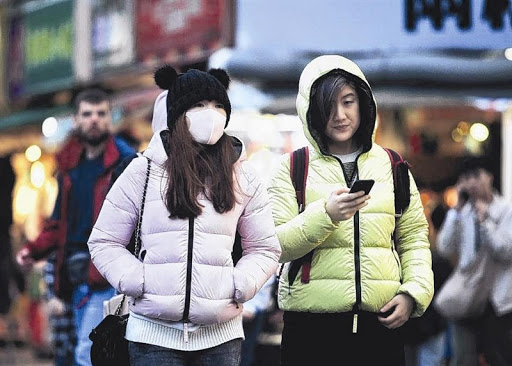

In [ ]:
import io

from PIL import Image
import requests

response = requests.get("https://face-masks-data.s3.us-east-2.amazonaws.com/all/images/maksssksksss0.png")
image = Image.open(io.BytesIO(response.content))
image

### Inspect an annotation file (Pascal VOC Format)

PASCAL VOC is a widely recognized annotation format for object detection, storing bounding boxes, object classes, and image metadata in XML files. Its structured design and common adoption by popular detection frameworks make it a standard choice for many computer vision tasks. For more details, see: http://host.robots.ox.ac.uk/pascal/VOC/

View the annotation for the above image, which is stored in Pascal VOC XML format. 


In [ ]:
!curl "https://face-masks-data.s3.us-east-2.amazonaws.com/all/annotations/maksssksksss0.xml"


<annotation>
    <folder>images</folder>
    <filename>maksssksksss0.png</filename>
    <size>
        <width>512</width>
        <height>366</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>without_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>79</xmin>
            <ymin>105</ymin>
            <xmax>109</xmax>
            <ymax>142</ymax>
        </bndbox>
    </object>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>185</xmin>
            <ymin>100</ymin>
            <xmax>226</xmax>
            <ymax>144</ymax>
        </bndbox>
    </object>
    <object>
        <name>without_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</


Observe some key fields:


* The `<size>` contains details about the image dimensions (width, height) and color depth. For instance, the following block tells us the image is 512 pixels wide, 366 pixels tall, and has 3 color channels (e.g., RGB). 

```xml
        <size>
          <width>512</width>
          <height>366</height>
          <depth>3</depth>
        </size>
```


* Each `<object>` block describes one annotated object in the image. `<name>` is the label for that object. In this dataset, it can be "with_mask" or "without_mask". "mask_weared_incorrect":

* Each `<object>` contains a `<bndbox>` tag, which specifies the coordinates of the bounding box, the rectangle that tightly encloses the object.

  - `<xmin>` and `<ymin>` are the top-left corner of the bounding box.
  - `<xmax>` and `<ymax>` are the bottom-right corner of the bounding box.


### Parse Pascal VOC annotations



The annotation files are in XML format; however, since Ray data lacks an XML parser, read the binary files directly from S3 using `ray.data.read_binary_files`.

Then, use `parse_voc_annotation` function to extract and parse XML annotation data from a binary input stored in the `bytes` field of a dataset record. It then processes the XML structure to extract bounding box coordinates, object labels, and the filename, returning them as NumPy arrays for further use.

In [ ]:
from typing import List, Tuple
import xmltodict
import numpy as np
import ray.data

# # Create a Ray Dataset from the S3 uri.
annotation_s3_uri = "s3://face-masks-data/train/annotations/"
ds = ray.data.read_binary_files(annotation_s3_uri)



In [ ]:

CLASS_TO_LABEL = {
    "background": 0,
    "with_mask": 1,
    "without_mask": 2,
    "mask_weared_incorrect": 3
}


def parse_voc_annotation(record) -> dict:
    xml_str = record["bytes"].decode("utf-8")
    if not xml_str.strip():
        raise ValueError("Empty XML string")

    annotation = xmltodict.parse(xml_str)["annotation"]

    # Normalize the object field to a list.
    objects = annotation["object"]
    if isinstance(objects, dict):
        objects = [objects]

    boxes: List[Tuple] = []
    for obj in objects:
        x1 = float(obj["bndbox"]["xmin"])
        y1 = float(obj["bndbox"]["ymin"])
        x2 = float(obj["bndbox"]["xmax"])
        y2 = float(obj["bndbox"]["ymax"])
        boxes.append((x1, y1, x2, y2))

    labels: List[int] = [CLASS_TO_LABEL[obj["name"]] for obj in objects]
    filename = annotation["filename"]

    return {
        "boxes": np.array(boxes),
        "labels": np.array(labels),
        "filename": filename
    }


annotations = ds.map(parse_voc_annotation)
annotations.take(2)

2025-02-25 20:44:56,911	INFO dataset.py:2699 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2025-02-25 20:44:56,917	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2025-02-25_20-40-22_741922_2443/logs/ray-data
2025-02-25 20:44:56,918	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[PartitionFiles] -> TaskPoolMapOperator[ReadFiles] -> TaskPoolMapOperator[Map(parse_voc_annotation)] -> LimitOperator[limit=2]


Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- PartitionFiles 2: 0.00 row [00:00, ? row/s]

- ReadFiles 3: 0.00 row [00:00, ? row/s]

- Map(parse_voc_annotation) 4: 0.00 row [00:00, ? row/s]

- limit=2 5: 0.00 row [00:00, ? row/s]

(autoscaler +19s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +19s) [autoscaler] [4CPU-8GB] Attempting to add 1 node(s) to the cluster (increasing from 0 to 1).
(autoscaler +19s) [autoscaler] Launched 1 instances.


[{'boxes': array([[321.,  34., 354.,  69.],
         [224.,  38., 261.,  73.],
         [299.,  58., 315.,  81.],
         [143.,  74., 174., 115.],
         [ 74.,  69.,  95.,  99.],
         [191.,  67., 221.,  93.],
         [ 21.,  73.,  44.,  93.],
         [369.,  70., 398.,  99.],
         [ 83.,  56., 111.,  89.]]),
  'labels': array([1, 1, 1, 1, 1, 1, 1, 1, 2]),
  'filename': 'maksssksksss1.png'},
 {'boxes': array([[ 98., 267., 194., 383.]]),
  'labels': array([1]),
  'filename': 'maksssksksss10.png'}]

### Batch image retrieval from S3
Next, fetch images from an S3 URL based on the filenames present in the batch dictionary. For each filename, check if the file has an appropriate image extension, construct the S3 URL, and then download and convert the image to an RGB NumPy array. After that, append all the loaded images into a new key "image" within the batch dictionary. 

Note that in Ray Data, the `map_batches` method only passes the batch of data to your function, meaning you can’t directly supply additional parameters like `images_s3_url`. To work around this, use `partial` to pre-bind the `images_s3_url` argument to your `read_images` function. The `read_images` function then takes just the batch (because that’s all map_batches provides) and uses the bound URL internally to fetch images from the S3 bucket. 

Note that you can use either a `function` or a `callable class` to perform the `map` or `map_batches` transformation:
* For **functions**, Ray Data uses stateless **Ray tasks**, which are ideal for simple tasks that don’t require loading heavyweight models.
* For **classes**, Ray Data uses stateful **Ray actors**, making them well-suited for more complex tasks that involve loading heavyweight models.

For more information, see : https://docs.ray.io/en/latest/data/api/doc/ray.data.Dataset.map.html and https://docs.ray.io/en/latest/data/api/doc/ray.data.Dataset.map_batches.html

In [ ]:
from typing import Dict
from PIL import Image
from functools import partial


def read_images(images_s3_url:str, batch: Dict[str, np.ndarray]) -> Dict[str, np.ndarray]:
    images: List[np.ndarray] = []

    for filename in batch["filename"]:

        if not filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".gif")):
            continue

        url = os.path.join(images_s3_url, filename)
        response = requests.get(url)
        image = Image.open(io.BytesIO(response.content)).convert("RGB")  # Ensure image is in RGB.

        images.append(np.array(image))
    batch["image"] = np.array(images, dtype=object)
    return batch


# URL for training images stored in S3.
train_images_s3_url = "https://face-masks-data.s3.us-east-2.amazonaws.com/train/images/"

# Bind the URL to your image reading function.
train_read_images = partial(read_images, train_images_s3_url)

# Map the image retrieval function over your annotations dataset.
train_dataset = annotations.map_batches(train_read_images)




### Set up Ray Train for distributed fine-tuning / training

This section configures and runs a distributed training loop using Ray Train. The training function handles several essential steps:

* **Defining the model**: Initializes a Faster R-CNN model.
* **Configuring the optimizer and scheduler**: Sets up the optimizer and learning rate scheduler for training.
* **Running the training loop**: Iterates over epochs and batches to update model parameters.
* **Checkpointing**: Saves checkpoints, but only on the primary (rank 0) worker to avoid redundant writes.

#### Distributed training with Ray Train

When launching a distributed training job, each worker executes this training function `train_func`.

  - **Without Ray Train**: You would train on a single machine or manually configure PyTorch’s `DistributedDataParallel` to handle data splitting, gradient synchronization, and communication among workers. This setup requires significant manual coordination.

  - **With Ray Train:**. Ray Train automatically manages parallelism. It launches multiple training processes (actors), each handling its own shard of the dataset. Under the hood, Ray synchronizes gradients among workers and provides features for checkpointing, metrics reporting, and more. The parallelism primarily occurs at the batch-processing step, with each worker handling a different portion of the data.

To learn more about Ray train, see: https://docs.ray.io/en/latest/train/overview.html



In [ ]:


import os
import torch
from torchvision import models

import ray
from ray import train

from torchvision import transforms
import tempfile
from tqdm.auto import tqdm


def train_func(config):
    # Get device
    device = ray.train.torch.get_device()

    # Define model
    model = models.detection.fasterrcnn_resnet50_fpn(num_classes=len(CLASS_TO_LABEL))
    model = ray.train.torch.prepare_model(model)

    # Define optimizer
    parameters = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(
        parameters,
        lr=config["lr"],
        momentum=config["momentum"],
        weight_decay=config["weight_decay"],
    )

    # Define learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer, milestones=config["lr_steps"], gamma=config["lr_gamma"]
    )


    for epoch in range(config["epochs"]):
        model.train()

        # Warmup learning rate scheduler for first epoch
        if epoch == 0:
            warmup_factor = 1.0 / 1000
            lr_scheduler = torch.optim.lr_scheduler.LinearLR(
                optimizer, start_factor=warmup_factor, total_iters=250
            )

        # Retrieve the training dataset shard for the current worker.
        train_dataset_shard = train.get_dataset_shard("train")
        batch_iter = train_dataset_shard.iter_batches(batch_size=config["batch_size"])
        batch_iter = tqdm(batch_iter, desc=f"Epoch {epoch+1}/{config['epochs']}", unit="batch")


        for batch_idx, batch in enumerate(batch_iter):
            inputs = [transforms.ToTensor()(image).to(device) for image in batch["image"]]
            targets = [
                {
                    "boxes": torch.as_tensor(boxes).to(device),
                    "labels": torch.as_tensor(labels).to(device),
                }
                for boxes, labels in zip(batch["boxes"], batch["labels"])
            ]

            # Forward pass through the model.
            loss_dict = model(inputs, targets)
            losses = sum(loss for loss in loss_dict.values())

             # Backpropagation.
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            # Step the learning rate scheduler.
            if lr_scheduler is not None:
                lr_scheduler.step()

            # Report metrics.
            current_worker = ray.train.get_context().get_world_rank()
            metrics = {
                "losses": losses.item(),
                "epoch": epoch,
                "lr": optimizer.param_groups[0]["lr"],
                **{key: value.item() for key, value in loss_dict.items()},
            }

            # Print batch metrics.
            print(f"Worker {current_worker} - Batch {batch_idx}: {metrics}")



        if lr_scheduler is not None:
            lr_scheduler.step()

        # Save a checkpoint on the primary worker for each epoch.
        if ray.train.get_context().get_world_rank() == 0:
            with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
                torch.save(
                    model.module.state_dict(), os.path.join(temp_checkpoint_dir, "model.pt")
                )
                checkpoint = ray.train.Checkpoint.from_directory(temp_checkpoint_dir)
                train.report(metrics, checkpoint=checkpoint)
        else: # Save metrics from all workers for each epoch.
            train.report(metrics)



#### How train.get_dataset_shard("train") works

A shard is a partition of the overall dataset allocated to a specific worker. For example, if you have 4 workers and 10,000 images, each worker receives 2,500 images (i.e., one shard of 2,500 each).

Ray Train automatically splits your dataset into shards across multiple workers. Calling `train.get_dataset_shard("train")` returns the subset (shard) of the dataset for the current worker. Each worker trains on a different shard in parallel. This approach contrasts with a typical single-machine PyTorch setup, where you might rely on PyTorch’s DataLoader or a DistributedSampler for data distribution. For more details: https://docs.ray.io/en/latest/train/api/doc/ray.train.get_dataset_shard.html


#### Batch size

The batch size specifies how many samples each worker processes in a single forward/backward pass. For instance, a batch size of 4 means each training step processes 4 samples within that worker’s shard before performing a gradient update.  In practice, you should carefully select the batch size based on the model size and GPU memory size. 

#### Checkpointing on the primary (rank 0) worker

In this example, all workers maintain the same model parameters. They are kept in sync during updates. Therefore, by the end of each epoch (or at checkpoint time), every worker’s model state is identical. Saving checkpoints from only the primary worker (rank 0) prevents redundant or conflicting writes and ensures one clear, consistent checkpoint.

To learn more about saving and loading checkpoints, see:https://docs.ray.io/en/latest/train/user-guides/checkpoints.html

#### Reporting metrics for all worker nodes

Use `train.report` to track metrics from **all worker nodes**. Ray Train’s internal bookkeeping records these metrics, enabling you to monitor progress and analyze results after training completes. 

**Note: You will receive errors if you only report the metrics from the primary worker, a common mistake to avoid.** 

### Launch the fine-tuning / training process with TorchTrainer

Configure and initiate training using TorchTrainer from Ray Train. Be patient, as this process may take some time.

**For demonstration purposes, set `epochs` to 2, but the performace of the fine-tuned model won't be optimal.** In practice, you would typically train for 20-30 epochs to achieve a well fine-tuned model.

The `num_workers` parameter specifies how many parallel worker processes will be started for data-parallel training. Set `num_workers=2` for demonstration purposes, but in real scenarios, the setting depends on:

* Your max number of available GPUs: Each worker can be assigned to one GPU (if use_gpu=True). Hence, if you have 4 GPUs, you could set num_workers=4.
* Desired training speed: More workers can lead to faster training because Ray Train splits the workload among multiple devices or processes. If your training data is large and you have the computational resources, you can increase `num_workers` to accelerate training.



In [ ]:

from ray.train.torch import TorchTrainer


storage_path = "/mnt/cluster_storage/face-mask-experiments_v1/"
run_config = ray.train.RunConfig(storage_path=storage_path, name="face-mask-experiments_v1")

trainer = TorchTrainer(
    train_func,
    train_loop_config={
        "batch_size": 4, # ajust it based on your GPU memory, a batch size that is too large could cause OOM issue
        "lr": 0.02,
        "epochs": 2,  # You'd normally train for 20-30 epochs to get a good performance.
        "momentum": 0.9,
        "weight_decay": 1e-4,
        "lr_steps": [16, 22],
        "lr_gamma": 0.1,
    },
    scaling_config = ray.train.ScalingConfig(num_workers=2, use_gpu=True),
    run_config = run_config,
    datasets={"train": train_dataset},
)

results = trainer.fit()


(TrainController pid=5760) Attempting to start training worker group of size 2 with the following resources: [{'GPU': 1}] * 2


(autoscaler +2m59s) [autoscaler] [1xT4:4CPU-16GB] Attempting to add 2 node(s) to the cluster (increasing from 0 to 2).
(autoscaler +2m59s) [autoscaler] Launched 2 instances.


(TrainController pid=5760) Retrying training worker group startup. The previous attempt encountered the following failure:
(TrainController pid=5760) Traceback (most recent call last):
(TrainController pid=5760)   File "/home/ray/anaconda3/lib/python3.12/site-packages/ray/train/v2/_internal/execution/worker_group/worker_group.py", line 261, in start
(TrainController pid=5760)     ray.get(pg.ready(), timeout=self._worker_group_start_timeout_s)
(TrainController pid=5760)   File "/home/ray/anaconda3/lib/python3.12/site-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
(TrainController pid=5760)     return fn(*args, **kwargs)
(TrainController pid=5760)            ^^^^^^^^^^^^^^^^^^^
(TrainController pid=5760)   File "/home/ray/anaconda3/lib/python3.12/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
(TrainController pid=5760)     return func(*args, **kwargs)
(TrainController pid=5760)            ^^^^^^^^^^^^^^^^^^^^^
(TrainController pid=5760)   F

(autoscaler +3m49s) [autoscaler] Cluster upscaled to {8 CPU, 1 GPU}.


(TrainController pid=5760) Retrying training worker group startup. The previous attempt encountered the following failure:
(TrainController pid=5760) Traceback (most recent call last):
(TrainController pid=5760)   File "/home/ray/anaconda3/lib/python3.12/site-packages/ray/train/v2/_internal/execution/worker_group/worker_group.py", line 261, in start
(TrainController pid=5760)     ray.get(pg.ready(), timeout=self._worker_group_start_timeout_s)
(TrainController pid=5760)   File "/home/ray/anaconda3/lib/python3.12/site-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
(TrainController pid=5760)     return fn(*args, **kwargs)
(TrainController pid=5760)            ^^^^^^^^^^^^^^^^^^^
(TrainController pid=5760)   File "/home/ray/anaconda3/lib/python3.12/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
(TrainController pid=5760)     return func(*args, **kwargs)
(TrainController pid=5760)            ^^^^^^^^^^^^^^^^^^^^^
(TrainController pid=5760)   F

(pid=6258) Running 0: 0.00 row [00:00, ? row/s]

(SplitCoordinator pid=6258) Starting execution of Dataset. Full logs are in /tmp/ray/session_2025-02-25_20-40-22_741922_2443/logs/ray-data
(SplitCoordinator pid=6258) Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[PartitionFiles] -> TaskPoolMapOperator[ReadFiles]


(autoscaler +4m4s) [autoscaler] Cluster upscaled to {12 CPU, 2 GPU}.


(RayTrainWorker pid=2283, ip=10.0.21.161) Setting up process group for: env:// [rank=0, world_size=2]
(RayTrainWorker pid=2263, ip=10.0.49.121) Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/ray/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
  0%|          | 0.00/97.8M [00:00<?, ?B/s]21) 
  7%|▋         | 7.00M/97.8M [00:00<00:01, 73.1MB/s]
100%|██████████| 97.8M/97.8M [00:00<00:00, 210MB/s]
(RayTrainWorker pid=2263, ip=10.0.49.121) Moving model to device: cuda:0
(RayTrainWorker pid=2263, ip=10.0.49.121) Wrapping provided model in DistributedDataParallel.
Epoch 1/2: 0batch [00:00, ?batch/s]0.0.49.121) 


(pid=6258) Running 0: 0.00 row [00:00, ? row/s]

(pid=6258) - ListFiles 1: 0.00 row [00:00, ? row/s]

(pid=6258) - PartitionFiles 2: 0.00 row [00:00, ? row/s]

(pid=6258) - ReadFiles 3: 0.00 row [00:00, ? row/s]

(pid=6258) - Map(parse_voc_annotation)->MapBatches(partial) 4: 0.00 row [00:00, ? row/s]

(pid=6258) - split(2, equal=True) 5: 0.00 row [00:00, ? row/s]

(SplitCoordinator pid=6258) Starting execution of Dataset. Full logs are in /tmp/ray/session_2025-02-25_20-40-22_741922_2443/logs/ray-data
(SplitCoordinator pid=6258) Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[PartitionFiles] -> TaskPoolMapOperator[ReadFiles] -> TaskPoolMapOperator[Map(parse_voc_annotation)->MapBatches(partial)] -> OutputSplitter[split(2, equal=True)]
(RayTrainWorker pid=2283, ip=10.0.21.161) Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/ray/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
  0%|          | 0.00/97.8M [00:00<?, ?B/s]61) 
100%|██████████| 97.8M/97.8M [00:00<00:00, 175MB/s] [repeated 8x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(RayTrainWorker pid=2283, ip=10.0.21.161) Mo

(pid=6258) Running 0: 0.00 row [00:00, ? row/s]

(pid=6258) - ListFiles 1: 0.00 row [00:00, ? row/s]

(pid=6258) - PartitionFiles 2: 0.00 row [00:00, ? row/s]

(pid=6258) - ReadFiles 3: 0.00 row [00:00, ? row/s]

(pid=6258) - Map(parse_voc_annotation)->MapBatches(partial) 4: 0.00 row [00:00, ? row/s]

(pid=6258) - split(2, equal=True) 5: 0.00 row [00:00, ? row/s]

(SplitCoordinator pid=6258) Starting execution of Dataset. Full logs are in /tmp/ray/session_2025-02-25_20-40-22_741922_2443/logs/ray-data
(SplitCoordinator pid=6258) Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[PartitionFiles] -> TaskPoolMapOperator[ReadFiles] -> TaskPoolMapOperator[Map(parse_voc_annotation)->MapBatches(partial)] -> OutputSplitter[split(2, equal=True)]
(RayTrainWorker pid=2263, ip=10.0.49.121) 
Epoch 1/2: 85batch [16:19,  1.48s/batch]/home/ray/anaconda3/lib/python3.12/site-packages/torchvision/transforms/functional.py:154: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc

### Inspect results when training completes

In [ ]:


print("Metrics reported during training:")
print(results.metrics)

print("\nLatest checkpoint reported during training:")
print(results.checkpoint)

print("\nPath where logs are stored:")
print(results.path)

print("\nException raised, if training failed:")
print(results.error)



Metrics reported during training:
{'losses': 0.07777648572283669, 'epoch': 1, 'lr': 0.013846159999999996, 'loss_classifier': 0.024532580748200417, 'loss_box_reg': 0.04629848152399063, 'loss_objectness': 0.004773554392158985, 'loss_rpn_box_reg': 0.0021718681271640753}

Latest checkpoint reported during training:
Checkpoint(filesystem=local, path=/mnt/cluster_storage/face-mask-experiments_v1/face-mask-experiments_v1/checkpoint_2025-02-25_21-16-58.709155)

Path where logs are stored:
/mnt/cluster_storage/face-mask-experiments_v1/face-mask-experiments_v1

Exception raised, if training failed:
None


### Run inference and visualize predictions on a test image
After training, run the model on a single test image for a sanity check:

* Download an image from a URL.
* Run the model for predictions.
* Visualize the detections (bounding boxes and labels).



In [ ]:
import io
import requests
import numpy as np
from PIL import Image, ImageDraw, ImageFont

# CLASS_TO_LABEL dictionary
CLASS_TO_LABEL = {
    "background": 0,
    "with_mask": 1,
    "without_mask": 2,
    "mask_weared_incorrect": 3
}

# Create reverse label mapping
LABEL_TO_CLASS = {v: k for k, v in CLASS_TO_LABEL.items()}

# Define colors for each category
LABEL_COLORS = {
    "with_mask": "green",
    "without_mask": "red",
    "mask_weared_incorrect": "yellow"
}

def load_image_from_url(url):
    """
    Downloads the image from the given URL and returns it as a NumPy array.
    """
    response = requests.get(url)
    response.raise_for_status()  # Raise an error if the download failed.
    image = Image.open(io.BytesIO(response.content)).convert("RGB")
    return np.array(image)

def predict_and_visualize(image_np, model, confidence_threshold=0.5):
    """Run model prediction on an image array and visualize results."""
    # Convert numpy array to PIL Image.
    image_pil = Image.fromarray(image_np)
    draw = ImageDraw.Draw(image_pil)
    font = ImageFont.load_default()

    # Preprocess image for model.
    image_tensor = torch.from_numpy(image_np).permute(2, 0, 1).float() / 255.0

    # Make prediction.
    with torch.no_grad():
        predictions = model([image_tensor])[0]  # Get first (and only) prediction

    # Filter predictions by confidence.
    keep = predictions["scores"] > confidence_threshold
    boxes = predictions["boxes"][keep]
    labels = predictions["labels"][keep]
    scores = predictions["scores"][keep]

    # Draw each detection.
    for box, label, score in zip(boxes, labels, scores):
        x1, y1, x2, y2 = box.tolist()

        # Convert numeric label back to class name.
        class_name = LABEL_TO_CLASS.get(label.item(), "unknown")

        # Get corresponding color.
        box_color = LABEL_COLORS.get(class_name, "white")  # Default to white if unknown.

        # Draw bounding box.
        draw.rectangle([x1, y1, x2, y2], outline=box_color, width=2)

        # Prepare text.
        text = f"{class_name} {score:.2f}"

        # Calculate text size.
        text_bbox = draw.textbbox((0, 0), text, font=font)
        text_width = text_bbox[2] - text_bbox[0]
        text_height = text_bbox[3] - text_bbox[1]

        # Draw text background.
        draw.rectangle(
            [x1, y1 - text_height - 2, x1 + text_width, y1],
            fill=box_color
        )

        # Draw text.
        draw.text(
            (x1, y1 - text_height - 2),
            text,
            fill="black" if box_color in ["yellow"] else "white",  # Ensure good contrast
            font=font
        )

    return image_pil


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/ray/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 221MB/s]


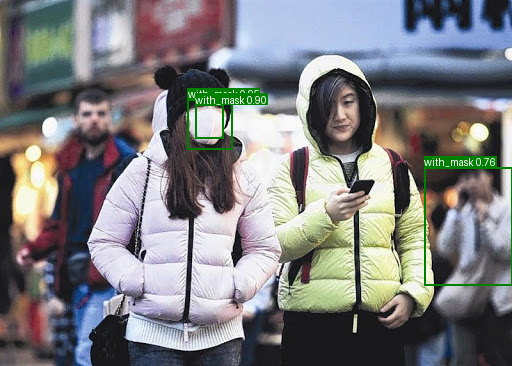

(autoscaler +34m19s) [autoscaler] Downscaling node i-01100c929786011c2 (node IP: 10.0.3.85) due to node idle termination.
(autoscaler +34m19s) [autoscaler] Cluster resized to {8 CPU, 2 GPU}.
(autoscaler +43m9s) [autoscaler] Downscaling node i-0710850cb19aac7a5 (node IP: 10.0.21.161) due to node idle termination.
(autoscaler +43m9s) [autoscaler] Downscaling node i-09dab0a72515cb0f4 (node IP: 10.0.49.121) due to node idle termination.
(autoscaler +1h48m59s) [autoscaler] [1xT4:4CPU-16GB] Attempting to add 2 node(s) to the cluster (increasing from 0 to 2).
(autoscaler +1h48m59s) [autoscaler] Launched 2 instances.
(autoscaler +1h49m59s) [autoscaler] Cluster upscaled to {8 CPU, 2 GPU}.
(autoscaler +2h5m19s) [autoscaler] Downscaling node i-02cef9eebb5e6d306 (node IP: 10.0.16.47) due to node idle termination.
(autoscaler +2h5m19s) [autoscaler] Downscaling node i-0f1e07a8ce02f15b9 (node IP: 10.0.57.13) due to node idle termination.
(autoscaler +2h14m44s) [autoscaler] [1xT4:4CPU-16GB] Attempting

In [ ]:
# Load model.
ckpt = results.checkpoint
with ckpt.as_directory() as ckpt_dir:
    model_path = os.path.join(ckpt_dir, "model.pt")
    model = models.detection.fasterrcnn_resnet50_fpn(num_classes=len(CLASS_TO_LABEL))
    state_dict = torch.load(model_path, map_location=torch.device("cpu"), weights_only=True)
    model.load_state_dict(state_dict)
    model.eval()

# URL for a test image.
url = "https://face-masks-data.s3.us-east-2.amazonaws.com/all/images/maksssksksss0.png"

# Load image from URL.
image_np = load_image_from_url(url)

# Run prediction and visualization.
result_image = predict_and_visualize(image_np, model, confidence_threshold=0.7)
result_image.show()

<div class="alert alert-block alert-warning"> <b> Note: You may notice that the results aren't optimal because we trained for only 2 epochs. 
Typically, training would require around 20 epochs.</b> 
<div>

### Store the trained model locally

After training, you can access the checkpoint, load the model weights, and save the model locally in your workspace. This allows you to easily download the model to your local machine, inspect the model, or do a sanity check. **Don't load the model and run batch inference directly from the workspace**, as this forcec the Ray cluster to copy the weights to other nodes, significantly slowing down the process. To enable faster batch inference, use Anyscale’s cluster storage to store the model instead.

```python
ckpt = results.checkpoint
with ckpt.as_directory() as ckpt_dir:
    model_path = os.path.join(ckpt_dir, "model.pt")
    model = models.detection.fasterrcnn_resnet50_fpn(num_classes=len(CLASS_TO_LABEL))
    state_dict = torch.load(model_path, map_location=torch.device('cpu'), weights_only=True)
    model.load_state_dict(state_dict)
    model.eval()

# Save the model locally.
save_path = "./saved_model/fasterrcnn_model_mask_detection.pth"  # Choose your path.
os.makedirs(os.path.dirname(save_path), exist_ok=True)  # Create directory if needed.
torch.save(model.state_dict(), save_path)
```

### Store the model on Anyscale Cluster Storage
You can store your model on Anyscale Cluster Storage (`/mnt/cluster_storage`) for faster batch inference or serving on Anyscale.  If your model needs to be accessed by multiple worker nodes in a distributed computing environment, storing it in cluster storage ensures all nodes load the model quickly and avoid redundant copies.

For more information, see: https://docs.anyscale.com/configuration/storage/


```python
ckpt = results.checkpoint
with ckpt.as_directory() as ckpt_dir:
    model_path = os.path.join(ckpt_dir, "model.pt")
    model = models.detection.fasterrcnn_resnet50_fpn(num_classes=len(CLASS_TO_LABEL))
    state_dict = torch.load(model_path, map_location=torch.device('cpu'), weights_only=True)
    model.load_state_dict(state_dict)
    model.eval()

# Save the model locally
save_path = "/mnt/cluster_storage/fasterrcnn_model_mask_detection.pth"  # Choose your path
os.makedirs(os.path.dirname(save_path), exist_ok=True)  # Create directory if needed
torch.save(model.state_dict(), save_path)
```


### Store the model in the cloud
You can store your model in a cloud such as AWS S3, Google Cloud Storage, or Hugging Face. Store the model remotely on a cloud helps your team collaboration, versioning, and efficient deployment and inference. Later on, you can use `smart-open` to load the model from AWS S3, Google Cloud Storage, or use AutoModel to load the model from Hugging Face. See how to load the model from AWS S3 in the next notebook.

This sample code uploads your model to AWS S3. Be sure to install the boto3 library properly configure it with AWS credentials:

```python
import os
import torch
import boto3
import smart_open
from torchvision import models

# Define S3 details
S3_BUCKET = "your-s3-bucket-name"
S3_KEY = "path/in/s3/fasterrcnn_model_mask_detection.pth"
S3_URI = f"s3://{S3_BUCKET}/{S3_KEY}"

# Load the model checkpoint
ckpt = results.checkpoint
with ckpt.as_directory() as ckpt_dir:
    model_path = os.path.join(ckpt_dir, "model.pt")
    model = models.detection.fasterrcnn_resnet50_fpn(num_classes=len(CLASS_TO_LABEL))
    state_dict = torch.load(model_path, map_location=torch.device('cpu'), weights_only=True)
    model.load_state_dict(state_dict)
    model.eval()

# Upload to S3 directly using smart_open
try:
    with smart_open.open(S3_URI, "wb") as f:
        torch.save(model.state_dict(), f)
    print(f"Model successfully uploaded to {S3_URI}")
except Exception as e:
    print(f"Error uploading to S3: {e}")

```


## Clean up the cluster storage

You can see the files you stored in the cluster_storage. You can see that you created `/mnt/cluster_storage/face-mask-experiments_v1/` to store the training artifacts.

In [ ]:
!ls -lah /mnt/cluster_storage/

**Remember to clean up the cluster storage by removing it:**

In [ ]:
!rm -rf /mnt/cluster_storage/face-mask-experiments_v1/

## Next steps

For the following notebooks, **Anyscale has already uploaded a fine-tuned mask detection model (with a batch size of 20) to AWS S3**. The following notebook demonstrates how to download the model to an Anyscale cluster for batch inference, among other tasks.

However, feel free to use your own fine-tuned model (around 20 epochs) if you prefer.